In [2]:
#import necessary packages
import networkx as nx
import numpy as np
from community import community_louvain #pip install python-louvain package
import leidenalg as la
import igraph as ig
import pandas as pd
import matplotlib

<h1>Read and format the data</h1>

In [3]:
# Load the exported Web of Science file
wos_data_orig = pd.read_csv('data/wos_export.csv')
#remove NANs from the Cited References Column
wos_data = wos_data_orig[wos_data_orig['Cited References'].notnull()]

In [4]:
# Extract cited references and reformat in to a list of sources (citing paper) and targets (cited paper)
cited_references = []
for index, row in wos_data.iterrows():
    refs = row['Cited References'].split('; ')
    for ref in refs:
        cited_references.append({
            'source': row['UT (Unique WOS ID)'],
            'target': ref
        })

# Create a DataFrame
citation_data = pd.DataFrame(cited_references)

# Save to a new CSV file
citation_data.to_csv('citation_data.csv', index=False)

<h1>Perform the analysis</h1>

Community 0: size=113, density=0.014696586599241467
Community 1: size=98, density=0.01094045865768988
Community 2: size=83, density=0.012342051131354687
Community 3: size=82, density=0.012797350195724179
Community 4: size=73, density=0.0136986301369863
Community 5: size=66, density=0.016083916083916083
Community 6: size=66, density=0.015151515151515152
Community 7: size=63, density=0.015873015873015872
Community 8: size=57, density=0.017857142857142856
Community 9: size=56, density=0.017857142857142856
Community 10: size=55, density=0.018518518518518517
Community 11: size=54, density=0.018518518518518517
Community 12: size=50, density=0.02
Community 13: size=43, density=0.023255813953488372
Community 14: size=42, density=0.023809523809523808
Community 15: size=40, density=0.025
Community 16: size=40, density=0.025
Community 17: size=37, density=0.02702702702702703
Community 18: size=36, density=0.027777777777777776
Community 19: size=35, density=0.02857142857142857
Community 20: size=3

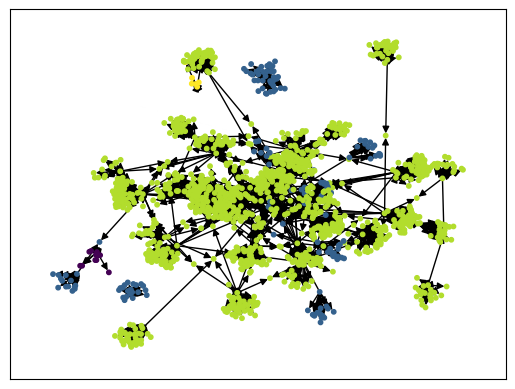

In [14]:
# Create a directed graph
G = nx.DiGraph()
G.add_edges_from(citation_data[['source', 'target']].values)

# Convert the NetworkX graph to an iGraph object
g = ig.Graph.TupleList(G.edges(), directed=True)

# Perform Leiden community detection
partition = la.find_partition(g, la.ModularityVertexPartition, n_iterations=10)

# Get the community assignments
community_ids = partition.membership

# Create a dictionary mapping nodes to community IDs
node_community = {node: community_id for node, community_id in zip(G.nodes(), community_ids)}

# Calculate community metrics (e.g., size, density)
community_metrics = {}
for community_id in set(community_ids):
    community_nodes = [node for node, cid in node_community.items() if cid == community_id]
    community_graph = G.subgraph(community_nodes)
    community_metrics[community_id] = {
        'size': len(community_nodes),
        'density': nx.density(community_graph)
    }

# Print community metrics
for community_id, metrics in community_metrics.items():
    print(f"Community {community_id}: size={metrics['size']}, density={metrics['density']}")

# Visualize the community structure (optional)
pos = nx.spring_layout(G)
colors = [community_ids[node_community[node]] for node in G.nodes()]

options = {
    'node_size': 10,
    'width': 1,
}
nx.draw_networkx(G, pos, node_color=colors, with_labels=False,cmap='viridis', **options)

plt.savefig("output.png")
plt.show()
